In [3]:
import os
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


### File Retrieval and Preprocessing

In [32]:
files = os.listdir('../final_stats/preprocessed_3/')
files[:2]

def split_target(df, target_col='away_winner_wts'):
    df = df.copy()
    target = df.pop(target_col)
    return df, target

def normalize_df(df):
    scaler = StandardScaler()
    data, target = split_target(df)
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    return data, target

def get_data(file):
    df = pd.read_csv(f'../final_stats/preprocessed_3/{file}', index_col=[0])
    data, target = normalize_df(df)
    return data, target



In [33]:
files

['preprocessed_no_sent_last_1.csv',
 'preprocessed_no_sent_last_3.csv',
 'preprocessed_no_sent_last_3_wt.csv',
 'preprocessed_no_sent_last_7.csv',
 'preprocessed_no_sent_last_7_wt.csv',
 'preprocessed_no_sent_last_ssn.csv',
 'preprocessed_no_sent_last_ssn_wt.csv',
 'preprocessed_sent_24_last_1.csv',
 'preprocessed_sent_24_last_3.csv',
 'preprocessed_sent_24_last_3_wt.csv',
 'preprocessed_sent_24_last_7.csv',
 'preprocessed_sent_24_last_7_wt.csv',
 'preprocessed_sent_24_last_ssn.csv',
 'preprocessed_sent_24_last_ssn_wt.csv',
 'preprocessed_sent_96_last_1.csv',
 'preprocessed_sent_96_last_3.csv',
 'preprocessed_sent_96_last_3_wt.csv',
 'preprocessed_sent_96_last_7.csv',
 'preprocessed_sent_96_last_7_wt.csv',
 'preprocessed_sent_96_last_ssn.csv',
 'preprocessed_sent_96_last_ssn_wt.csv',
 'preprocessed_sent_cross_last_1.csv',
 'preprocessed_sent_cross_last_3.csv',
 'preprocessed_sent_cross_last_3_wt.csv',
 'preprocessed_sent_cross_last_7.csv',
 'preprocessed_sent_cross_last_7_wt.csv',
 'pr

In [30]:
files[2]

'preprocessed_no_sent_last_3_wt.csv'

In [34]:
print(files[2])
x, y = get_data(files[2])
x.head()
y.head()

preprocessed_no_sent_last_3_wt.csv


0    1
1    0
2    0
3    0
4    0
Name: away_winner_wts, dtype: int64

### Chart Code

In [7]:
def get_average_acc_history(acc_histories):
    num_epochs = len(acc_histories[0])
    return [np.mean([x[i] for x in acc_histories]) for i in range(num_epochs)]

def get_average_loss_history(loss_histories):
    num_epochs = len(loss_histories[0])
    return [np.mean([x[i] for x in loss_histories]) for i in range(num_epochs)]
        
def plot_ave_acc_and_loss_histories(acc_histories, loss_histories):
    average_acc_history = get_average_acc_history(acc_histories)
    average_loss_history = get_average_loss_history(loss_histories)

    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")

    plt.subplot(1, 2, 2)

    plt.plot(range(1, len(average_loss_history) + 1), average_loss_history)
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.show()

def compare_ave_loss_acc_histories(acc_hist_1, acc_hist_2, loss_hist_1, loss_hist_2):
    min_epochs = min(len(acc_hist_1[0]), len(acc_hist_2[0]))
    
    ave_acc_hist_1 = get_average_acc_history(acc_hist_1)
    ave_loss_hist_1 = get_average_loss_history(loss_hist_1)
    
    ave_acc_hist_2 = get_average_acc_history(acc_hist_2)
    ave_loss_hist_2 = get_average_loss_history(loss_hist_2)


    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    epochs = range(1, min_epochs + 1)
    plt.figure(figsize=(15,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, ave_acc_hist_1, solid_blue_line, label='Model 1')
    plt.plot(epochs, ave_acc_hist_2, solid_red_line, label='Model 2')
    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(epochs, ave_loss_hist_1, solid_blue_line, label='Model 1')
    plt.plot(epochs, ave_loss_hist_2, solid_red_line, label='Model 2')
    plt.xlabel("Epochs")
    plt.ylabel("Validation Loss")
    plt.legend()
    
    plt.show()
    

In [8]:
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Repeated K-Fold Cross Validation
Limited in dataset so want to run a few times
Grid search of the learning rate and the n-estimators perameter
No hold out test set but k=10 and n_repeats = 10 for a total of 100

In [102]:

n_ests = [10, 25, 50, 100, 500, 750, 1000, 3000, 5000]
learn_rates = [0.01, 0.1, 1, 2, 5, 10, 25, 50, 100, 200]
base_est_depths = [1, 3]

def grid_search(X_train, y_train, f, n_ests, learn_rates, base_depths, base_est='dt'):
    max_score = {
        'scores_mean': 0
    }
    
    all_scores = []
    total_iters = len(n_ests)*len(learn_rates)*len(base_depths)
    curr_iter = 0
    for n in n_ests:
        for learn_rate in learn_rates:
            for depth in base_depths:
                curr_iter = curr_iter + 1
                if base_est == 'dt':
                    base = DecisionTreeClassifier(max_depth=depth)
                elif base_est == 'svm':
                    base = SVC(probability=True, kernel='linear')

                clf = AdaBoostClassifier(
                    base_estimator = base,
                    n_estimators = n, 
                    learning_rate = learn_rate, 
                    random_state = 99
                )

                cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)

                scores = cross_val_score(
                    clf, 
                    X_train, 
                    y_train, 
                    scoring='accuracy', 
                    cv=cv, 
                    n_jobs=-1
                )
                print(f'{curr_iter}/{total_iters} \t {f} \t Accuracy: {scores.mean()*100}')
                
                scores_dict = {
                    'scores_mean': scores.mean(),
                    'scores_std': scores.std(),
                    'n': n,
                    'depth': depth,
                    'learn_rate': learn_rate,
                    'scores': scores,
                    'file': f
                }
                all_scores.append(scores_dict)

                if scores.mean() > max_score['scores_mean']:
                    max_score = scores_dict
    return all_scores, max_score


Test n_ests holding learn rate and base depth stable. Find n_est 500 best. 
Hold n_ests at 500. Hold Base_est_depth. Test Learn rates.
Best learning rate = 10 was highest lr so check new lrs.
Best LR 15 again so increase learning rate spectrum.
Learning rate getting very large so just scrapped and doing full grid search to see how learning rate and n_ests interact. Sklearn notes a tradeoff between these two params


n_est initial test found best accuracy at max n_etsts so increase options and retest

In [57]:
x, y = get_data(files[3])
all_scores, max_score = grid_search(x,y, n_ests, learn_rates, [1], 'dt')
all_scores

[{'scores_mean': 0.39799999999999996,
  'scores_std': 0.11999021998713888,
  'n': 10,
  'depth': 1,
  'learn_rate': 0.01,
  'scores': array([0.27272727, 0.45454545, 0.63636364, 0.63636364, 0.27272727,
         0.2       , 0.4       , 0.4       , 0.2       , 0.6       ,
         0.45454545, 0.36363636, 0.45454545, 0.54545455, 0.18181818,
         0.4       , 0.        , 0.3       , 0.6       , 0.4       ,
         0.45454545, 0.36363636, 0.27272727, 0.45454545, 0.45454545,
         0.2       , 0.3       , 0.3       , 0.5       , 0.3       ,
         0.45454545, 0.54545455, 0.45454545, 0.27272727, 0.45454545,
         0.5       , 0.3       , 0.3       , 0.4       , 0.4       ,
         0.36363636, 0.36363636, 0.45454545, 0.54545455, 0.36363636,
         0.5       , 0.3       , 0.4       , 0.5       , 0.3       ,
         0.36363636, 0.45454545, 0.45454545, 0.27272727, 0.36363636,
         0.6       , 0.2       , 0.4       , 0.4       , 0.5       ,
         0.45454545, 0.45454545, 0.36363

In [12]:
def get_best_params(all_scores):
    ms = max(all_scores, key=lambda x:x['scores_mean'])
    print(f"Accuracy: {round(ms['scores_mean']*100,2)}%")
    print(f"Best Paramaters: \nn_estimators: {ms['n']} \t learning_rate: {ms['learn_rate']} \t depth: {ms['depth']}")

In [58]:
get_best_params(all_scores)

Accuracy: 58.09%
Best Paramaters: 
n_estimators: 10 	 learning_rate: 25 	 depth: 1


In [73]:
get_best_params(all_scores)

Accuracy: 64.15%
Best Paramaters: 
n_estimators: 1000 	 learning_rate: 0.1 	 depth: 1


### Full Grid Search for DT Base
Ran on dataset of last 7 games no sentiment  

```n_ests = [10, 25, 50, 100, 300, 400, 500, 750, 1000]  ```  
```learn_rates = [0.01, 0.1, 1, 2, 5, 10, 25, 50, 100, 200]  ```  
```base_est_depths = 1```  

### Best Result DT Base:
#### Accuracy: **64.15%**  
Best Paramaters:   
n_estimators: 1000  
learning_rate: 0.1  
depth: 1

In [74]:
all_scores2, max_score2 = grid_search(x,y, [1000, 1250, 1500, 2000], [0.01, 0.1, 1], [1], 'dt')


In [75]:
get_best_params(all_scores2)

Accuracy: 64.51%
Best Paramaters: 
n_estimators: 2000 	 learning_rate: 0.1 	 depth: 1


In [10]:
all_scores3, max_score3 = grid_search(x,y, [2500, 3000], [0.05, 0.1, 0.5], [1], 'dt')

In [13]:
get_best_params(all_scores3)

Accuracy: 65.5%
Best Paramaters: 
n_estimators: 2500 	 learning_rate: 0.05 	 depth: 1


In [54]:
x,y = get_data(files[3])
all_scores4, max_score4 = grid_search(x,y, [1000], [0.05], [1], 'dt')

In [55]:
get_best_params(all_scores4)

Accuracy: 51.27%
Best Paramaters: 
n_estimators: 1000 	 learning_rate: 0.05 	 depth: 1


In [60]:
get_best_params(all_scores_svm)

Accuracy: 40.78%
Best Paramaters: 
n_estimators: 600 	 learning_rate: 0.01 	 depth: 1


### Full Grid Search for SVM Base
```n_ests = [10, 25, 50, 100, 300, 400, 500, 600, 700]  ```  
```learn_rates = [0.01, 0.1, 1, 2, 5, 10, 25, 50, 100, 200]  ```  
```base_est_depths = 1```  

### Best Result SVM Base:
#### Accuracy: **40.78%**  
Best Paramaters:   
n_estimators: 600  
learning_rate: 0.01  
depth: 1

Decision Tree Base much better, use that for further models.

### Run for every non sentiment dataset


In [106]:
def all_datasets(files):
    n_ests = [10, 50, 75, 100, 150, 200, 500, 1000]
    learn_rates = [0.01, 0.05, 0.1, 0.5, 1, 5]
    base_est_depths = [1]
    # n_ests = [10, 50]
    # learn_rates = [0.01, 100, 200]
    # base_est_depths = [1]
    
    results = []

    for f in files:
        print('FILE:', f)
        x, y = get_data(f)
        all_scores, max_score = grid_search(x,y, f, n_ests, learn_rates, base_est_depths, 'dt')
        # all_scores, max_score = grid_search(x,y, [50], [1], [1], 'dt')
        results.append(max_score)
        print(max_score)
        df = pd.DataFrame.from_records([max_score], index ='file')
        df.to_csv(f'../results/ada/sent_results_{f}')
    return results

In [92]:
no_sent_files = files[:7]

5 hours to run 7 files

In [93]:
no_sent_results = all_datasets(no_sent_files)

FILE: preprocessed_no_sent_last_1.csv
Iteration 1/56
Iteration 2/56
Iteration 3/56
Iteration 4/56
Iteration 5/56
Iteration 6/56
Iteration 7/56
Iteration 8/56
Iteration 9/56
Iteration 10/56
Iteration 11/56
Iteration 12/56
Iteration 13/56
Iteration 14/56
Iteration 15/56
Iteration 16/56
Iteration 17/56
Iteration 18/56
Iteration 19/56
Iteration 20/56
Iteration 21/56
Iteration 22/56
Iteration 23/56
Iteration 24/56
Iteration 25/56
Iteration 26/56
Iteration 27/56
Iteration 28/56
Iteration 29/56
Iteration 30/56
Iteration 31/56
Iteration 32/56
Iteration 33/56
Iteration 34/56
Iteration 35/56
Iteration 36/56
Iteration 37/56
Iteration 38/56
Iteration 39/56
Iteration 40/56
Iteration 41/56
Iteration 42/56
Iteration 43/56
Iteration 44/56
Iteration 45/56
Iteration 46/56
Iteration 47/56
Iteration 48/56
Iteration 49/56
Iteration 50/56
Iteration 51/56
Iteration 52/56
Iteration 53/56
Iteration 54/56
Iteration 55/56
Iteration 56/56
{'scores_mean': 0.6173636363636364, 'scores_std': 0.15671258631885254, 'n':

In [94]:
df_no_sent_results = pd.DataFrame.from_records(no_sent_results, index ='file').sort_values('scores_mean', ascending=False)
df_no_sent_results

,scores_mean,scores_std,n,depth,learn_rate,scores
file,,,,,,
preprocessed_no_sent_last_1.csv,0.617364,0.156713,100,1,0.1,"[0.6363636363636364, 0.6363636363636364, 0.363..."
preprocessed_no_sent_last_7.csv,0.563091,0.145766,10,1,10.0,"[0.6363636363636364, 0.45454545454545453, 0.54..."
preprocessed_no_sent_last_7_wt.csv,0.563091,0.145766,10,1,10.0,"[0.6363636363636364, 0.45454545454545453, 0.54..."
preprocessed_no_sent_last_3.csv,0.553545,0.153880,100,1,10.0,"[0.45454545454545453, 0.8181818181818182, 0.45..."
preprocessed_no_sent_last_3_wt.csv,0.553545,0.153880,100,1,10.0,"[0.45454545454545453, 0.8181818181818182, 0.45..."
preprocessed_no_sent_last_ssn.csv,0.530909,0.126980,5000,1,1.0,"[0.5454545454545454, 0.45454545454545453, 0.72..."
preprocessed_no_sent_last_ssn_wt.csv,0.530909,0.126980,5000,1,1.0,"[0.5454545454545454, 0.45454545454545453, 0.72..."


In [95]:
df_no_sent_results.to_csv('../results/ada_resust_no_sent2.csv')

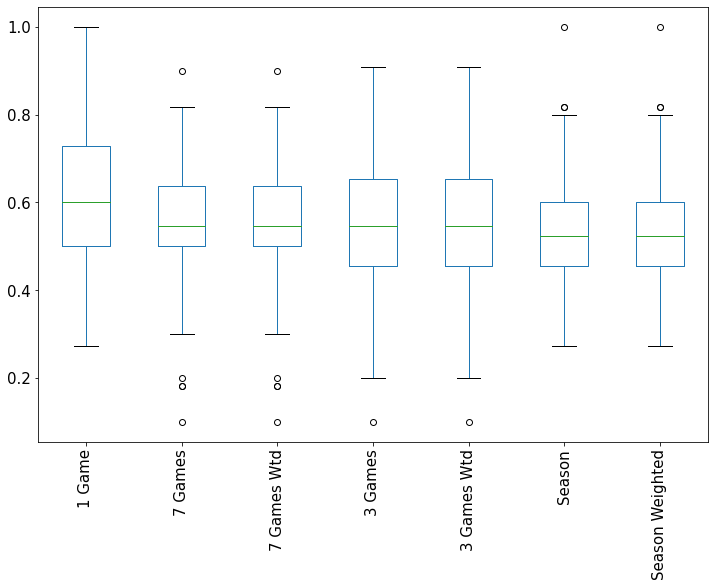

In [96]:
column_dict_no_sent = {
    'preprocessed_no_sent_last_7.csv': '7 Games',
    'preprocessed_no_sent_last_7_wt.csv': '7 Games Wtd',
    'preprocessed_no_sent_last_1.csv': '1 Game',
    'preprocessed_no_sent_last_3.csv': '3 Games',
    'preprocessed_no_sent_last_3_wt.csv': '3 Games Wtd',
    'preprocessed_no_sent_last_ssn.csv': 'Season',
    'preprocessed_no_sent_last_ssn_wt.csv': 'Season Weighted',
}
def get_box_plot(df, col_labels):
    scores = df['scores'].apply(pd.Series).transpose()
    # print(scores.columns)
    scores = scores.rename(columns=col_labels)
    scores.boxplot(rot=90, figsize=(12,8), grid=False, fontsize=15)

get_box_plot(df_no_sent_results, column_dict_no_sent)

1 game best result so use that for this dataset

In [107]:
files_1_game = [f for f in files if 'last_1' in f]
files_1_game

['preprocessed_no_sent_last_1.csv',
 'preprocessed_sent_24_last_1.csv',
 'preprocessed_sent_96_last_1.csv',
 'preprocessed_sent_cross_last_1.csv']

In [108]:
one_game_results = all_datasets(files_1_game)

FILE: preprocessed_no_sent_last_1.csv
1/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 46.24545454545454
2/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 47.76363636363636
3/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 48.38181818181818
4/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 53.75454545454546
5/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 51.154545454545456
6/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 56.45454545454546
7/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 49.72727272727272
8/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 58.98181818181819
9/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 59.0
10/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 55.83636363636364
11/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 55.56363636363636
12/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 56.24545454545454
13/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 51.81818181818182
14/48 	 preprocessed_no_sent_last_1.csv 	 Accuracy: 61.427272727272744
15

In [111]:
df_sent_results = pd.DataFrame.from_records(one_game_results, index ='file').sort_values('scores_mean', ascending=False)
df_sent_results

,scores_mean,scores_std,n,depth,learn_rate,scores
file,,,,,,
preprocessed_sent_cross_last_1.csv,0.652091,0.136065,75,1,0.10,"[0.6363636363636364, 0.8181818181818182, 0.818..."
preprocessed_no_sent_last_1.csv,0.620545,0.156446,75,1,0.10,"[0.6363636363636364, 0.6363636363636364, 0.272..."
preprocessed_sent_96_last_1.csv,0.596455,0.147799,75,1,0.10,"[0.6363636363636364, 0.6363636363636364, 0.636..."
preprocessed_sent_24_last_1.csv,0.596091,0.140990,75,1,0.05,"[0.45454545454545453, 0.7272727272727273, 0.45..."


In [112]:
df_sent_results.to_csv('../results/ada_result_sent.csv')

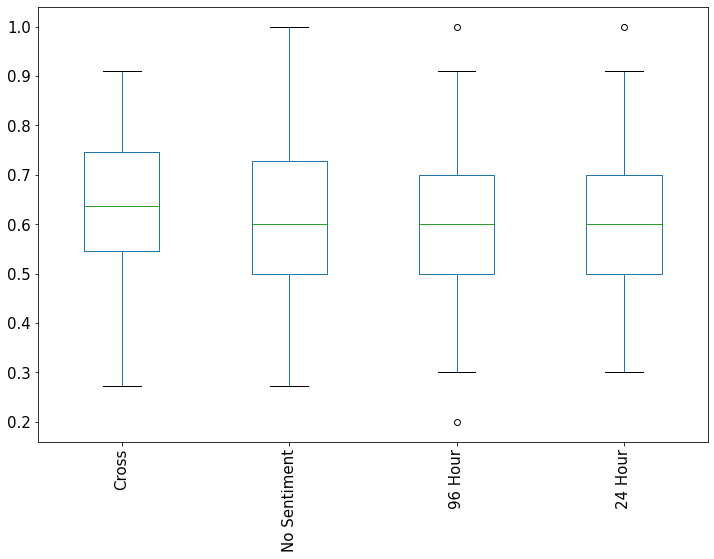

In [114]:
column_dict_sent = {
    'preprocessed_no_sent_last_1.csv': 'No Sentiment',
    'preprocessed_sent_24_last_1.csv': '24 Hour',
    'preprocessed_sent_96_last_1.csv': '96 Hour',
    'preprocessed_sent_cross_last_1.csv': 'Cross'
}
get_box_plot(df_sent_results, column_dict_sent)

### Old Chart Code Functions

In [63]:
def plot_train_val_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.plot(epochs, loss, blue_dots, label = 'Training loss')
    plt.plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_train_val_acc(history):
    plt.clf()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
        
    epochs = range(1, len(acc) + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
        
    plt.plot(epochs, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.title('Training and validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

def plot_train_val_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)
    blue_dots = 'bo'
    solid_blue_line = 'b'

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    # plt.plot(epochs_range, acc, label='Training Accuracy')
    # plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    
 
    plt.plot(epochs_range, acc, blue_dots, label = 'Training Accuracy')
    plt.plot(epochs_range, val_acc, solid_blue_line, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, blue_dots, label='Training Loss')
    plt.plot(epochs_range, val_loss, solid_blue_line, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
  
def compare_loss_and_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['loss']), len(hist2.history['loss']))
    
    train_loss_1 = hist1['loss'][:min_epochs]
    val_loss_1 = hist1['val_loss'][:min_epochs]

    train_loss_2 = hist2['loss'][:min_epochs]
    val_loss_2 = hist2['val_loss'][:min_epochs]


    train_acc_1 = hist1['accuracy'][:min_epochs]
    val_acc_1 = hist1['val_accuracy'][:min_epochs]

    train_acc_2 = hist2['accuracy'][:min_epochs]
    val_acc_2 = hist2['val_accuracy'][:min_epochs]

    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)

    plt.plot(epochs, train_loss_1, blue_dots, label = f'{title1} Training Loss')
    plt.plot(epochs, val_loss_1, solid_blue_line, label = f'{title1} Validation Loss')
    plt.plot(epochs, train_loss_2, red_dots, label = f'{title2} Training Loss')
    plt.plot(epochs, val_loss_2, solid_red_line, label = f'{title2} Validation Loss')
    # plt.title('Loss With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_1, blue_dots, label = f'{title1} Training Accuracy')
    plt.plot(epochs, val_acc_1, solid_blue_line, label = f'{title1} Validation Accuracy')
    plt.plot(epochs, train_acc_2, red_dots, label = f'{title2} Training Accuracy')
    plt.plot(epochs, val_acc_2, solid_red_line, label = f'{title2} Validation Accuracy')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

def compare_acc(hist1, hist2, title1, title2): 
    min_epochs = min(len(hist1.history['accuracy']), len(hist2.history['accuracy']))
    acc = hist1.history['accuracy'][:min_epochs]
    val_acc = hist1.history['val_accuracy'][:min_epochs]
    acc_drop = hist2.history['accuracy'][:min_epochs]
    val_acc_drop = hist2.history['val_accuracy'][:min_epochs]
    
    epochs = range(1, min_epochs + 1)

    blue_dots = 'bo'
    solid_blue_line = 'b'
    red_dots = 'ro'
    solid_red_line = 'r'

    plt.plot(epochs, acc, blue_dots, label = f'{title1} Training Accuracy')
    plt.plot(epochs, val_acc, solid_blue_line, label = f'{title1} Validation Accuracy')
    plt.plot(epochs, acc_drop, red_dots, label = f'{title2} Training Accuracy')
    plt.plot(epochs, val_acc_drop, solid_red_line, label = f'{title2} Validation Accuracy')
    # plt.title('Accuracy With Dropout Layers')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()